# Start

In [1]:
from IPython.display import display 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import dateutil.parser
# import statsmodels.api as sm

# import yfinance as yf
# from yahoo_earnings_calendar import YahooEarningsCalendar
import akshare as ak
pd.set_option('display.max_rows', 500)

%matplotlib inline
sns.set_context(font_scale=2)

# SP500 index

## Download and preprocessing

In [2]:
stock_us_daily_df = ak.stock_us_daily(symbol="SPY", adjust="")
print(stock_us_daily_df.tail())

           date    open    high     low   close       volume
5780 2023-12-26  474.07  476.58  473.99  475.65   55386952.0
5781 2023-12-27  475.44  476.66  474.89  476.51   68000311.0
5782 2023-12-28  476.88  477.55  476.26  476.69   77158109.0
5783 2023-12-29  476.49  477.03  473.30  475.31  122283086.0
5784 2024-01-02  472.16  473.67  470.49  472.65  122930433.0


In [12]:
df = stock_us_daily_df.copy()
price_type = 'close'  # Using 'open' yields larger variance and lower gains
df['price'] = df[price_type]
df = df.drop(['open', 'high', 'low', 'close'], axis=1)

# Get year, month, day, etc.
df = df.sort_values('date')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_month'] = df['date'].dt.day  # day of month
df['week_of_year'] = df['date'].dt.isocalendar().week  # day of month
df['day_of_week'] = df['date'].dt.dayofweek  # day of month

df.head(1)

,date,volume,price,year,month,day_of_month,week_of_year,day_of_week
0,2001-01-02,8732200.0,128.81,2001,1,2,1,1


In [13]:
# Get weekly price using close price of the week
df['last_day_of_week'] = df.groupby(['year', 'week_of_year'])['day_of_week'].transform('max')
df_weekly_raw = df[df['day_of_week'] == df['last_day_of_week']].drop(['day_of_week'], axis=1)

df_weekly_raw['week_of_month'] = df_weekly_raw.groupby(['year', 'month'])['date'].rank()
df_weekly_raw['week_of_month_reverse'] = df_weekly_raw.groupby(['year', 'month'])['date'].rank(ascending=False)

In [14]:
def shift_weeks(df, n_week_shift):
    df_weekly = df.copy()
    df_weekly['date_out'] = df_weekly['date'].shift(n_week_shift)
    df_weekly['price_out'] = df_weekly['price'].shift(n_week_shift)
    
    # d_price at weeky m is the difference with price at n and price at m
    df_weekly['d_price'] = df_weekly['price_out'] - df_weekly['price']
    df_weekly = df_weekly.set_index('date')
    return df_weekly

## Explore the stats of n week price diff

### The n to the last Friday of each month - compare the gains
**If buying in on the 2nd to the last Friday of October, one gets the most gain after 6 weeks**  
March is another month with large gain and relatively low risk

[(-6, 1, 6.071818181818173), (-6, 2, 7.433181818181819), (-6, 3, 6.750454545454548), (-6, 4, 6.711818181818183)]


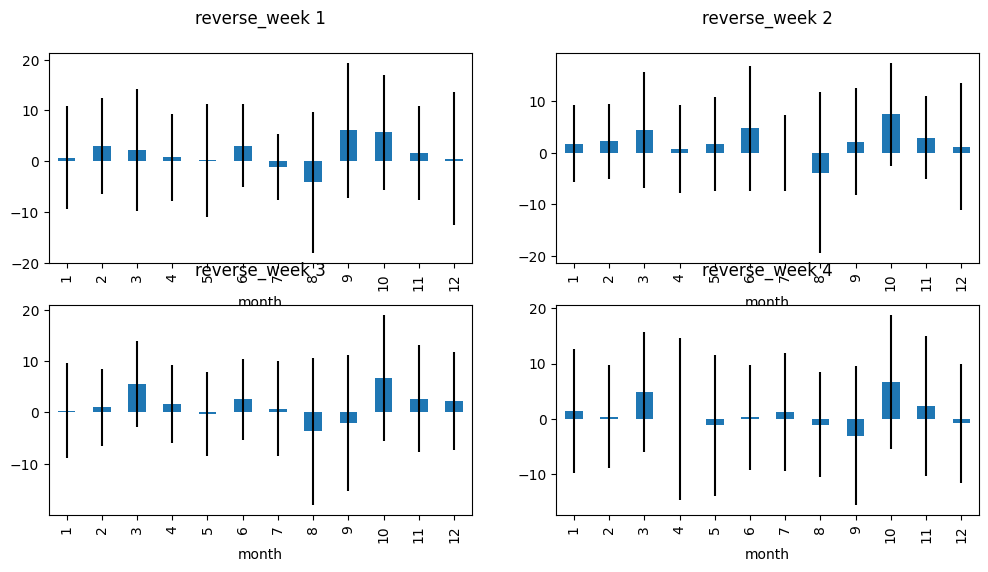

In [15]:
# Get the price change over an n-week span. Tried changing N manually and 6 is the best
n = -6
df_weekly = shift_weeks(df_weekly_raw, n)

# Skip 2020 covid - The result holds for Oct, but March changes a lot
year_skip = 2020

fig = plt.figure(figsize=(12, 6))
max_time = []
for i in range(1, 5):
    ax = fig.add_subplot(2, 2, i)
    df_plot = df_weekly[(df_weekly.week_of_month_reverse == i) & (df_weekly.year != year_skip)].groupby('month')['d_price']
    df_plot.mean().plot(kind='bar', title=f'reverse_week {i}\n', ax=ax, yerr=df_plot.std())
    # print(i, df_weekly[(df_weekly.week_of_month_reverse == i)].groupby('month')['d_price'].quantile([0.1, 0.25, 0.5, 0.75, 0.9]))
    max_time.append((n, i, df_plot.mean().max()))
print(max_time)

### Boxplot comparison of the purchased month, when buying on the 2nd to the last Friday
**Oct has high median and highest q10**

<Axes: title={'center': 'd_price'}, xlabel='month'>

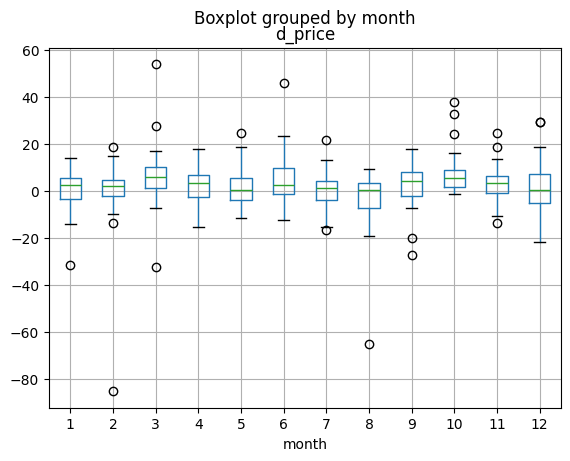

In [16]:
week_plot_reverse = 2
df_weekly[(df_weekly.week_of_month_reverse == week_plot_reverse)].boxplot(column='d_price', by='month')

### Price change of individual year when choosing the aforementioned strategy
**to buy in on the 2nd to the last Friday of October, and sell after 6 weeks**

<Axes: title={'center': 'd_price of month 10, reverse week 2; mean: 3.8'}, xlabel='date'>

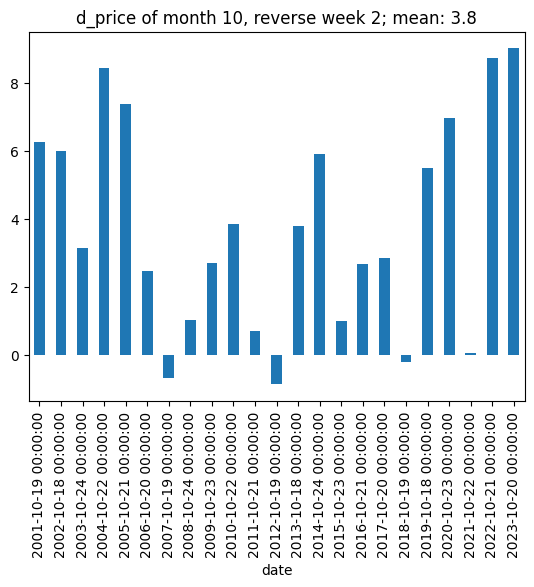

In [17]:
month_plot = 10
df_weekly_week_plot = (df_weekly[(df_weekly.month == month_plot) & (df_weekly.week_of_month_reverse == week_plot_reverse)]).copy()
df_weekly_week_plot['d_percent'] = df_weekly_week_plot['d_price'] / df_weekly_week_plot['price'] * 100
plot_var = 'd_percent'
df_weekly_week_plot[plot_var].plot(kind='bar', 
                                    title=f'''d_price of month {month_plot}, reverse week {week_plot_reverse}; mean: {df_weekly_week_plot[plot_var].mean():.2}''')

# df_weekly_week_plot[['price', 'date_out', 'price_out', 'd_price', 'd_percent']]

In [18]:
df_weekly_week_plot[plot_var]

date
2001-10-19    6.241267
2002-10-18    5.990523
2003-10-24    3.128017
2004-10-22    8.418947
2005-10-21    7.381698
2006-10-20    2.470038
2007-10-19   -0.674818
2008-10-24    1.022518
2009-10-23    2.710955
2010-10-22    3.836079
2011-10-21    0.717916
2012-10-19   -0.864774
2013-10-18    3.790355
2014-10-24    5.890139
2015-10-23    1.011951
2016-10-21    2.663800
2017-10-20    2.858699
2018-10-19   -0.217195
2019-10-18    5.490486
2020-10-23    6.961074
2021-10-22    0.066208
2022-10-21    8.715167
2023-10-20    9.000689
Name: d_percent, dtype: float64

## Explore the effect of holding time

### Starting 2nd to the last Friday in Oct
**The best is 6 weeks**

In [19]:
month_plot = 10
week_plot_reverse = 2
results = []
for n in range(-4, -13, -1):
    df_weekly = shift_weeks(df_weekly_raw, n)
    df_weekly_week_plot = df_weekly[(df_weekly.month == month_plot)
        & (df_weekly.week_of_month_reverse == week_plot_reverse)
        # & (df_weekly.year != year_skip)  # This doesn't matter for Oct
    ]
    results.append((-n, 
                    df_weekly_week_plot['d_price'].mean(), 
                    df_weekly_week_plot['d_price'].quantile(0.1),
                    df_weekly_week_plot['d_price'].quantile(0.25),
                    df_weekly_week_plot['d_price'].quantile(0.5),))    

<Axes: xlabel='holding_week'>

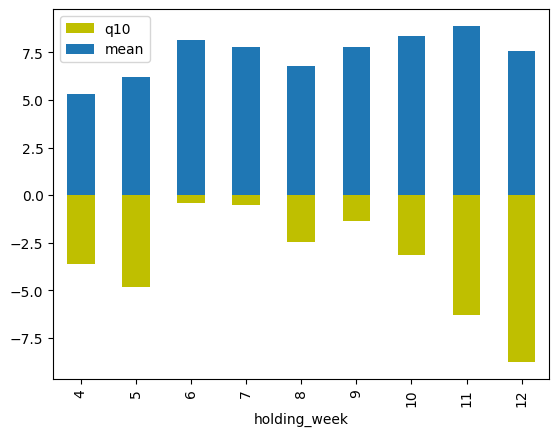

In [20]:
df_result = pd.DataFrame(results, columns=['holding_week', 'mean', 'q10', 'q25', 'q50'])
f, a = plt.subplots()
df_result.plot(x='holding_week', y='q10', kind='bar', color='y', ax=a)
df_result.plot(x='holding_week', y='mean', kind='bar', ax=a)

## Specific cases for October - what the raw price data looks like
This shows detailed timing for purchase and sale and helps determine the strategy  
See ON for the strategies

In [379]:
def plot_price_history(df, years=None, week_of_month_reverse=2, month=10, rows_fig=3, cols_fig=3):
    df_oct_v = df if years is None else df[df.year.isin(years)]
    grouped = df_oct_v.groupby('year')
    f = plt.figure(figsize=(20, 14))
    i = 0
    for year, group in grouped:
        i += 1
        ax = f.add_subplot(rows_fig, cols_fig, i)
        group = group.set_index('date')  # axvline and plot use different logic for x, I need to make sure they are consistent
        group.plot(y='price', ax=ax, title=year)
        x_value = group[(group.week_of_month_reverse==week_of_month_reverse) & (group.month==month)].index.values
        # pdb.set_trace()
        ax.axvline(x=x_value, alpha=0.5, color='y')
        ax.axvline(x=x_value - pd.Timedelta(weeks=4), alpha=0.5, color='grey')
        ax.axvline(x=x_value + pd.Timedelta(weeks=6), alpha=0.5, color='grey')

In [441]:
df_oct = df_weekly_raw[df_weekly_raw.month.isin((7, 8, 9, 10, 11, 12))]
# plot_price_history(df_oct, rows_fig=4, cols_fig=6)

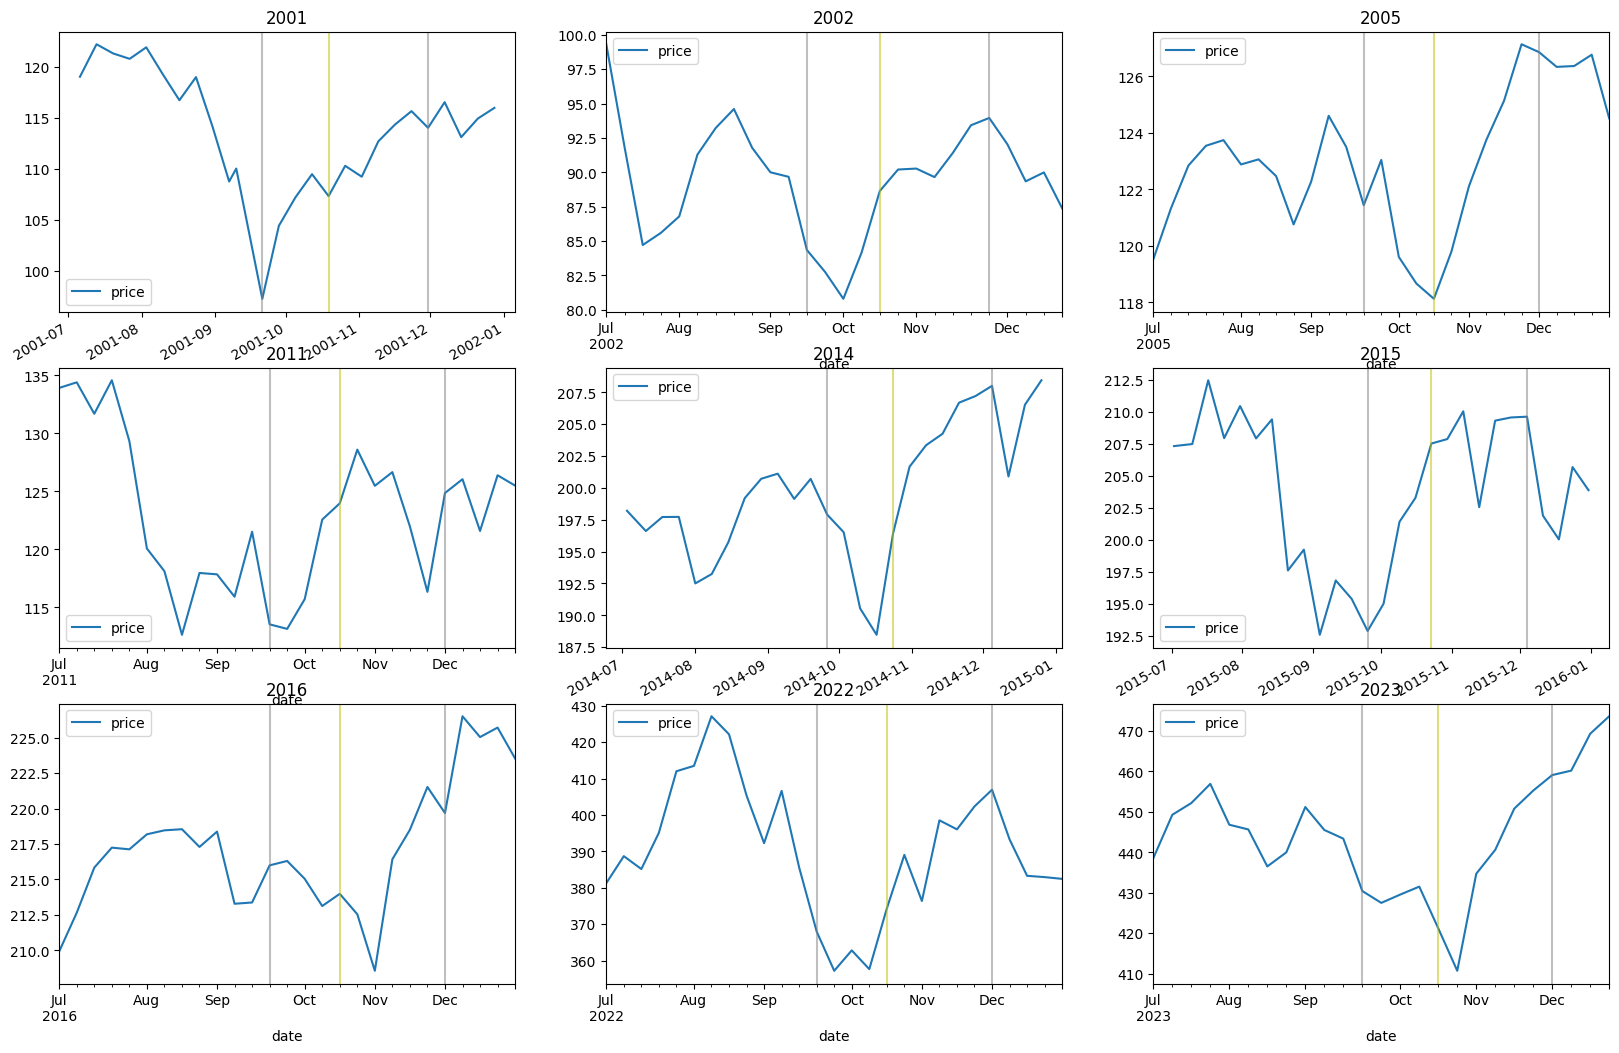

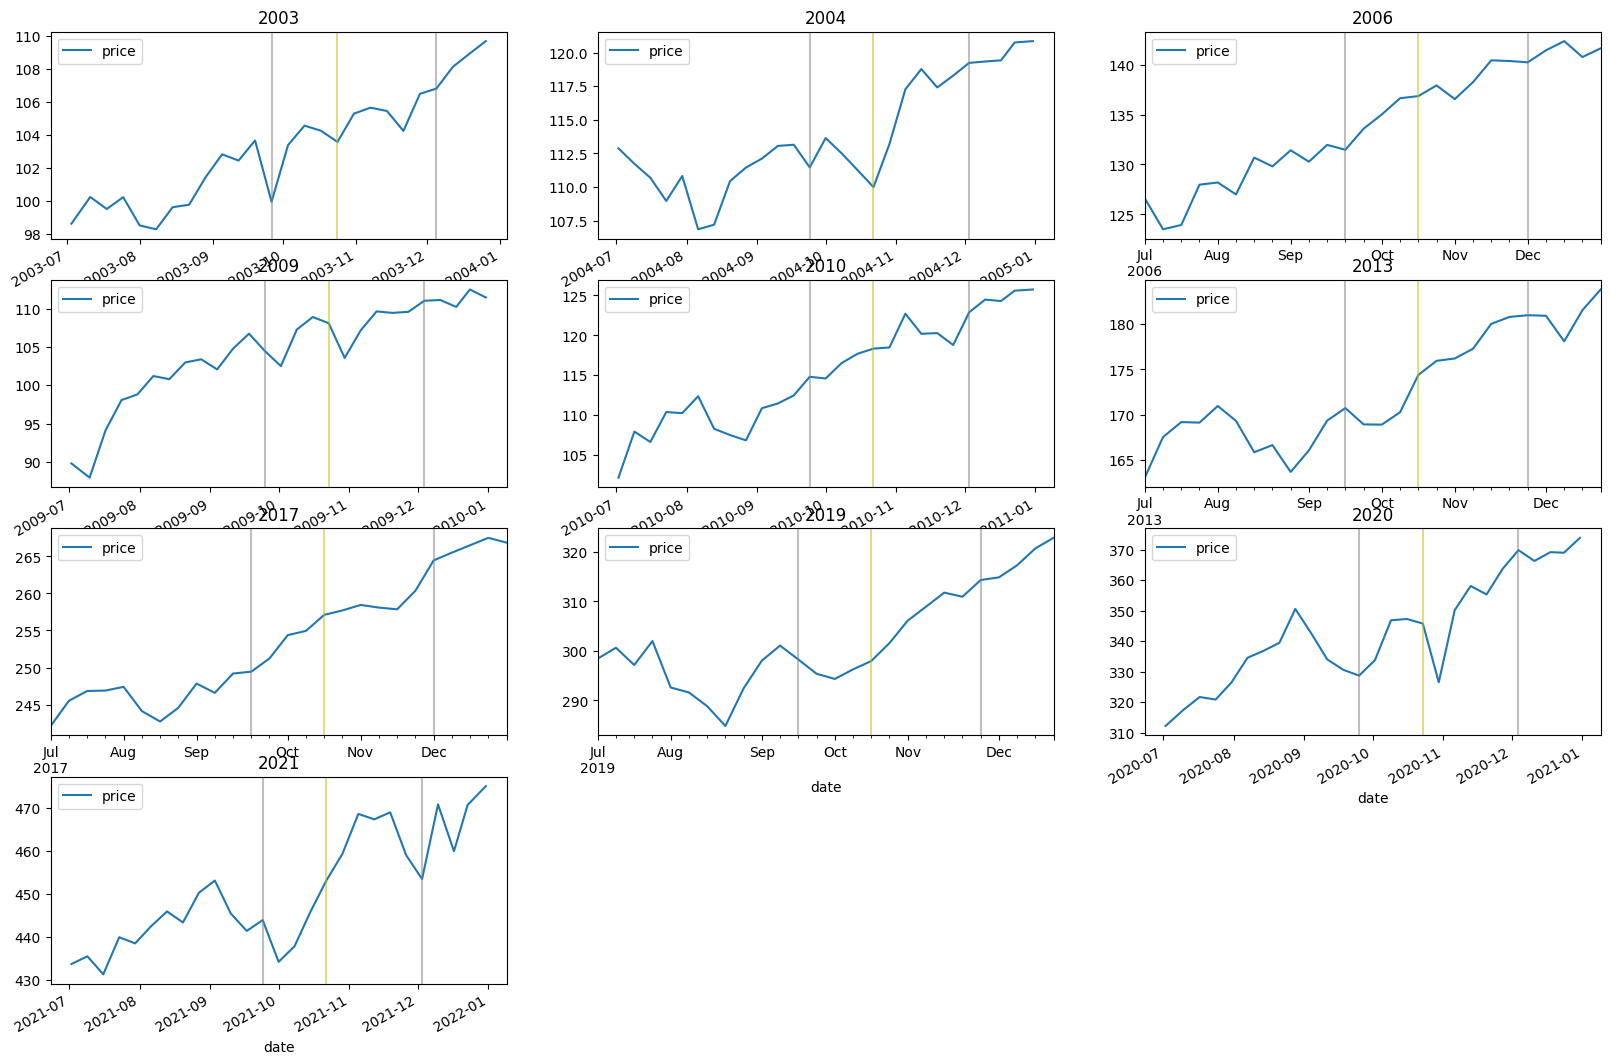

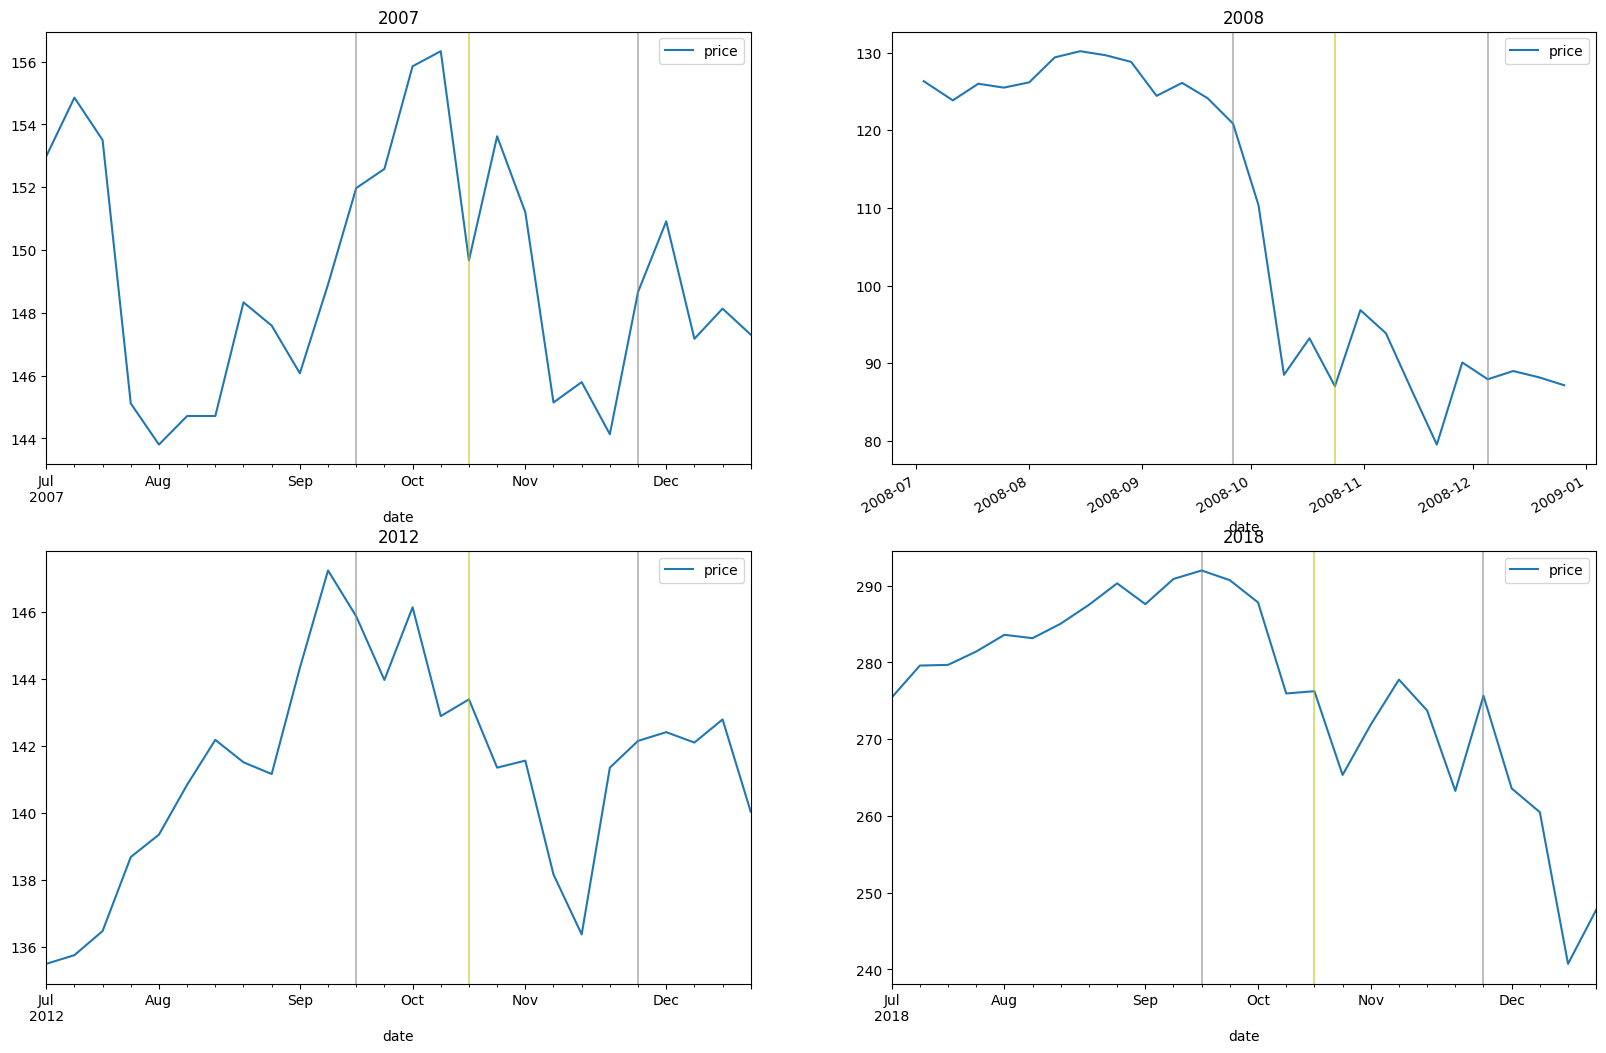

In [380]:
year_v = [2001, 2002, 2005, 2011, 2014, 2015, 2016, 2022, 2023]
year_up = [2003, 2004, 2006, 2009, 2010, 2013, 2017, 2019, 2020, 2021]
year_bad = [2007, 2008, 2012, 2018]
plot_price_history(df_oct, years=year_v, cols_fig=3, rows_fig=3)
plot_price_history(df_oct, years=year_up, cols_fig=3, rows_fig=4)
plot_price_history(df_oct, years=year_bad, cols_fig=2, rows_fig=2)

## Starting in March
- March is another month with possible consistent gains
- One needs to skip 2020 covid for March
- The best results come from buying in on the 3rd to last Friday, and selling after 6 weeks
- 2018 is special as both Oct and Mar strategy failed, need to investigate

<Axes: title={'center': 'd_price mean and quantiles when buying from the [1, 2, 3]nd to last Friday'}, xlabel='holding_week'>

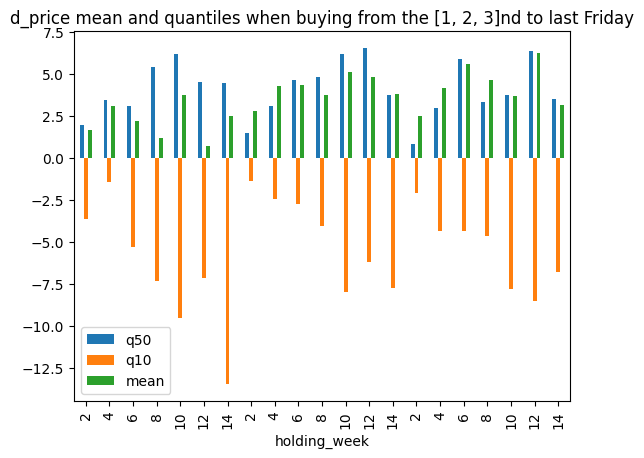

In [24]:
# Get weekly price using close price of the week
month_plot = 3  
# Skip 2020 covid shutdown for March
year_skip = 2020

# Loop to see the best combination of reverse weeks and holding time
# Best means high mean and low q10 (risk)
results = []
week_plot_reverse_list = range(1, 4)
for week_plot_reverse in week_plot_reverse_list:
    for n in range(-2, -15, -2):
        df_weekly = shift_weeks(df_weekly_raw, n)
        df_weekly_week_plot = df_weekly[(df_weekly.month == month_plot) & 
                                        (df_weekly.week_of_month_reverse == week_plot_reverse) &
                                        (df_weekly.year != year_skip) ]
        results.append((-n, 
                        week_plot_reverse,
                        df_weekly_week_plot['d_price'].mean(), 
                        df_weekly_week_plot['d_price'].quantile(0.1),
                        df_weekly_week_plot['d_price'].quantile(0.25),
                        df_weekly_week_plot['d_price'].quantile(0.5),))    

df_result = pd.DataFrame(results, columns=['holding_week', 'reverse_week', 'mean', 'q10', 'q25', 'q50'])
f, a = plt.subplots()
df_result.plot(x='holding_week', y=['q50', 'q10', 'mean'], kind='bar', ax=a,
              title=f'd_price mean and quantiles when buying from the {list(week_plot_reverse_list)}nd to last Friday')

<Axes: title={'center': 'd_price of month 3, reverse week 3; holding for 6 weeks; mean: 3.1'}, xlabel='date'>

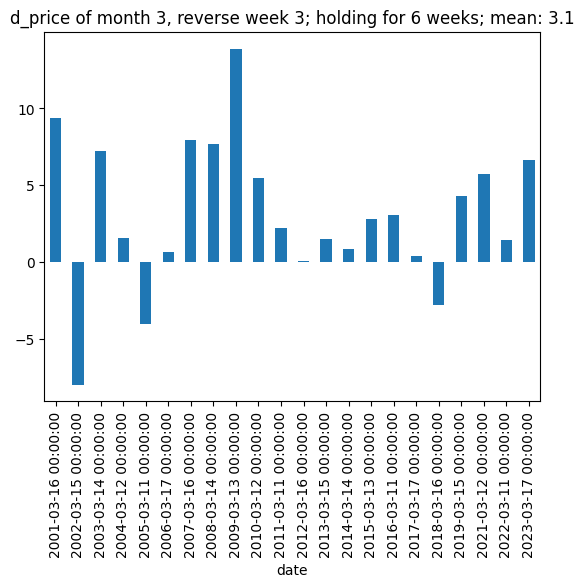

In [25]:
# Price change of individual years with the best combination
n = -6
month_plot = 3
week_plot_reverse = 3 #

df_weekly = shift_weeks(df_weekly_raw, n)
df_weekly_week_plot = (df_weekly[(df_weekly.month == month_plot) & (df_weekly.week_of_month_reverse == week_plot_reverse) & (df_weekly.year != year_skip)]).copy()
df_weekly_week_plot['d_percent'] = df_weekly_week_plot['d_price'] / df_weekly_week_plot['price'] * 100
plot_var = 'd_percent'
df_weekly_week_plot[plot_var].plot(kind='bar', 
                                    title=f'''d_price of month {month_plot}, reverse week {week_plot_reverse}; holding for {-n} weeks; mean: {df_weekly_week_plot[plot_var].mean():.2}''')

# df_weekly_week_plot[['price', 'date_out', 'price_out', 'd_price', 'd_percent']]

In [23]:
df_mar = df_weekly_raw[df_weekly_raw.month.isin((1, 2, 3, 4, 5))]
# plot_price_history(df_mar, rows_fig=6, cols_fig=4, month=month_plot, week_of_month_reverse=week_plot_reverse)

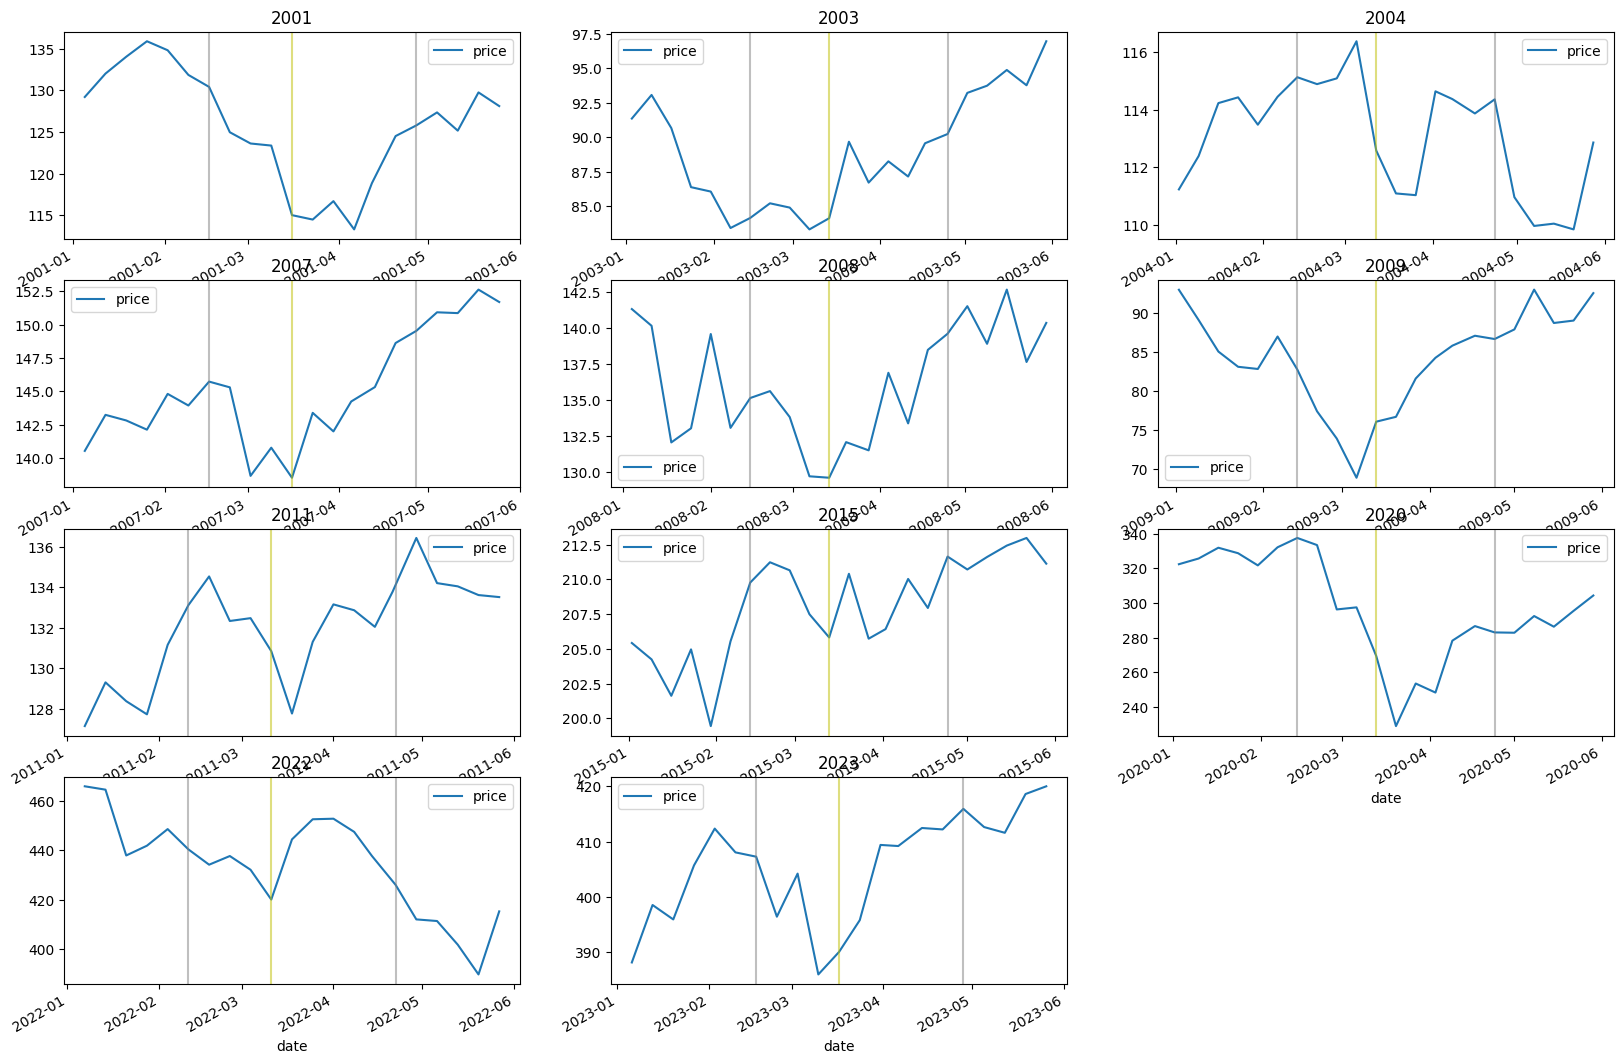

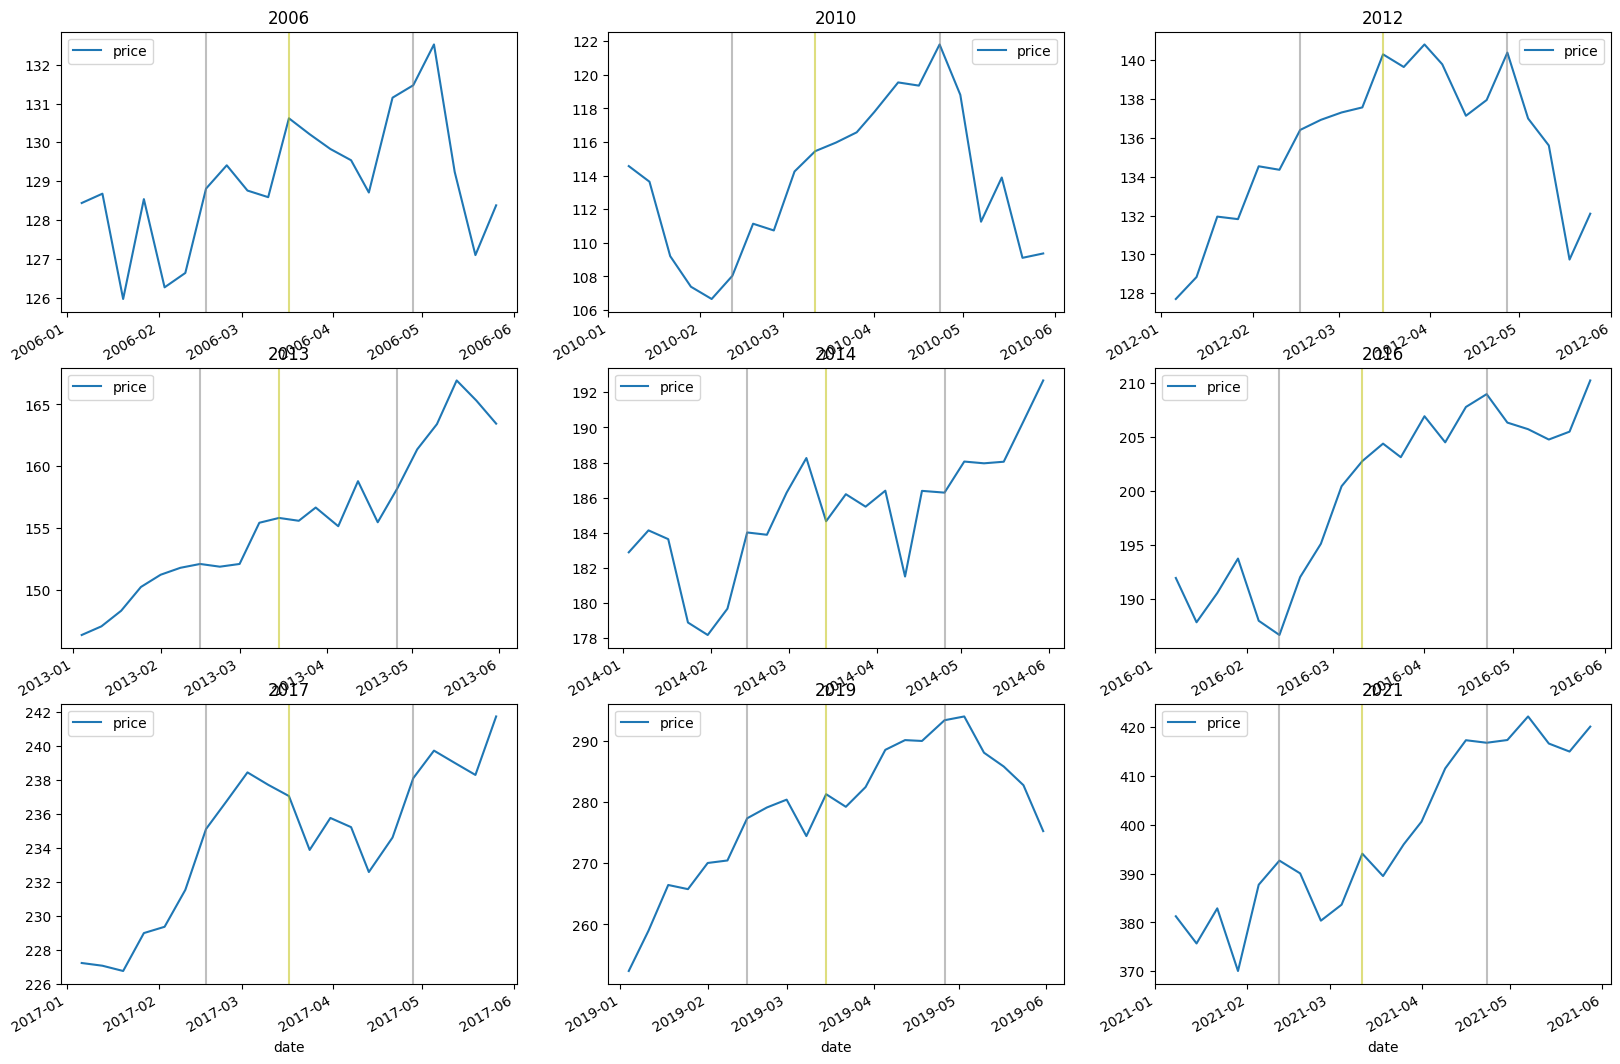

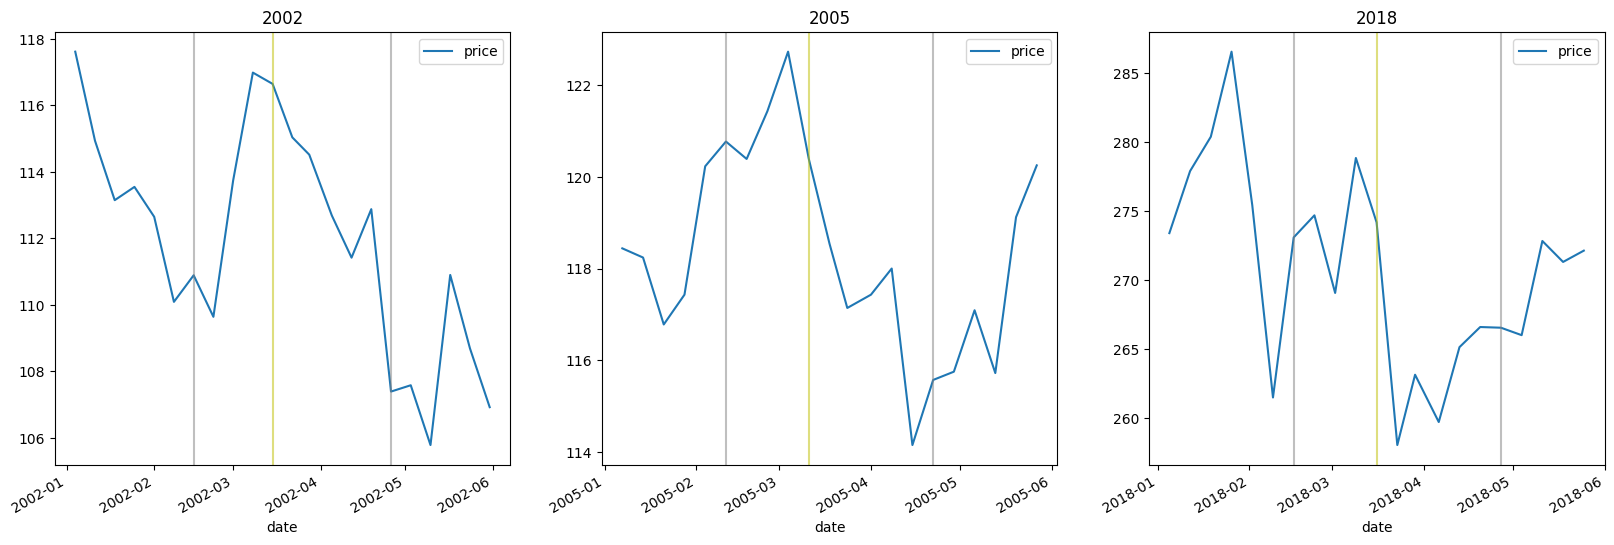

In [449]:
year_v_mar = [2001, 2003, 2004, 2007, 2008, 2009, 2011, 2015, 2020, 2022, 2023,]
year_up_mar = [2006, 2010, 2012, 2013, 2014, 2016, 2017, 2019, 2021,]
year_v_reverse_mar = [2002, 2005, 2018, ]

plot_price_history(df_mar, years=year_v_mar, cols_fig=3, rows_fig=4, month=month_plot, week_of_month_reverse=week_plot_reverse)
plot_price_history(df_mar, years=year_up_mar, cols_fig=3, rows_fig=3, month=month_plot, week_of_month_reverse=week_plot_reverse)
plot_price_history(df_mar, years=year_v_reverse_mar, cols_fig=3, rows_fig=2, month=month_plot, week_of_month_reverse=week_plot_reverse)